In [2]:
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras import optimizers,regularizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2
import warnings

In [4]:
!pip install pydub
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import re
import os
import wave
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio, display
import librosa as lib
import librosa.display

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH = "/content/drive/MyDrive/Colab Notebooks/Speech_Emotion/Crema"
AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/Speech_Emotion/Crema/1001_DFA_ANG_XX.wav"

In [7]:
def zeroCrossingRate(audio):
  return lib.feature.zero_crossing_rate(audio)

In [8]:
def energy(audio):
  # using a spectrogram will give a more accurate representation
  # of energy over time because its frames can be windowed
  S, phase = lib.magphase(lib.stft(audio))
  return lib.feature.rms(S=S).mean()

In [9]:
def chromaStft(audio, sr):
  stft = np.abs(librosa.stft(audio))
  return librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).mean()

In [10]:
def mfcc(data, sr):
  return librosa.feature.mfcc(y=data, sr=sr, n_fft=200).mean()

In [11]:
def melSpectrogram(audio, sr):
  mel_spectrogram = lib.feature.melspectrogram(y=audio, sr=sr, n_fft=200, n_mels=64)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [12]:
def playAudio(audio_file):
  audio = AudioSegment.from_wav(audio_file)
  # Play the audio
  audio.export('temp_audio.wav', format='wav')
  audio_data = open('temp_audio.wav', 'rb').read()
  display(Audio(audio_data))
  # Delete the temporary audio file
  os.remove('temp_audio.wav')

In [13]:
def visualize_waveform(audio, sr):
    plt.figure(figsize=(12, 4))
    plt.plot(audio)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.show()

In [14]:
def splitData(dataset_path):
  audio_files = glob.glob(os.path.join(dataset_path, "*.wav"))
  audio_train, audio_test = train_test_split(audio_files, test_size=0.3, random_state=42, shuffle=True)
  return audio_train, audio_test

In [15]:
D_train, D_test = splitData(PATH)

In [16]:
print(len(D_train), len(D_test))

5209 2233


In [17]:
D_test[0]

'/content/drive/MyDrive/Colab Notebooks/Speech_Emotion/Crema/1026_TIE_HAP_XX.wav'

In [18]:
def getMaxLen(audio_files):
  max_length = 0
  for audio_file in audio_files:
    audio, _ = librosa.load(audio_file)
    length = len(audio)
    max_length = max(max_length, length)
  return max_length

In [19]:
def loadAudioTime(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    #mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
  
  return D, Y

In [20]:
def loadAudioFreq(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
 
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    
  return D, Y

## Time Domain Model Without Augmentation

In [ ]:
D_time, Y_time = loadAudioTime(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [ ]:
D_time = np.array(D_time)
D_time.shape

(5216, 303)

In [ ]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_time = pd.DataFrame(Y_time)
df_time.head()

,0
0,FEA
1,FEA
2,HAP
3,HAP
4,ANG


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [ ]:
Y_time = one_hot_labels
Y_time.shape

(5216, 6)

In [ ]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [ ]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((4955, 200), (4955, 6), (261, 200), (261, 6))
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 198, 128)          512       
                                                                 
 batch_normalization_14 (Bat  (None, 198, 128)         512       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 198, 128)          0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
155/155 [==============================] - 9s 26ms/step - loss: 3.5802 - accuracy: 0.3033 - val_loss: 3.8121 - val_accuracy: 0.1736
Epoch 2/50
155/155 [==============================] - 3s 19ms/step - loss: 2.9867 - accuracy: 0.3401 - val_loss: 3.6998 - val_accuracy: 0.1429
Epoch 3/50
155/155 [==============================] - 4s 23ms/step - loss: 2.7038 - accuracy: 0.3659 - val_loss: 3.0281 - val_accuracy: 0.2390
Epoch 4/50
155/155 [==============================] - 3s 22ms/step - loss: 2.5256 - accuracy: 0.3736 - val_loss: 2.7559 - val_accuracy: 0.2559
Epoch 5/50
155/155 [==============================] - 3s 22ms/step - loss: 2.4104 - accuracy: 0.3839 - val_loss: 2.5245 - val_accuracy: 0.3187
Epoch 6/50
155/155 [==============================] - 4s 23ms/step - loss: 2.3233 - accuracy: 0.3897 - val_loss: 2.2665 - val_accuracy: 0.3974
Epoch 7/50
155/155 [==============================] - 3s 18ms/step - loss: 2.2265 - accuracy: 0.4075 - val_loss: 2.2751 - val_accuracy: 0.3941

In [ ]:
X_test_time,Y_test_time = loadAudioTime(D_test)
D_test_pca = pca.transform(X_test_time)

In [ ]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

,0
0,FEA
1,SAD
2,HAP
3,DIS
4,FEA


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(2236, 6)


In [ ]:
Y_time = one_hot_labels
Y_time.shape

(2236, 6)

70/70 [==============================] - 1s 6ms/step
Accuracy: 0.3761180679785331
F-score: 0.3734301464695326


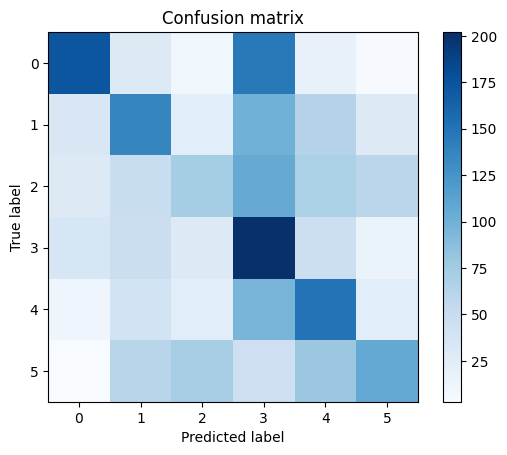

Most confusing classes: (0, 3)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

## Frequency Domain Model Without Augmentation

In [20]:
D_freq, Y_freq = loadAudioFreq(D_train)

In [ ]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

,0
0,FEA
1,FEA
2,HAP
3,HAP
4,ANG


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [ ]:
Y_freq = one_hot_labels
Y_freq.shape

(5216, 6)

In [ ]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [ ]:
D_freq.shape

(5216, 64, 256)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((4955, 64, 256), (4955, 6), (261, 64, 256), (261, 6))


In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(4955, 64, 256, 1) (261, 64, 256, 1)


In [ ]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - 6s 98ms/step - loss: 1.9998 - accuracy: 0.1976 - val_loss: 1.7112 - val_accuracy: 0.3487
Epoch 2/50
39/39 [==============================] - 2s 54ms/step - loss: 1.6651 - accuracy: 0.2991 - val_loss: 1.5374 - val_accuracy: 0.4023
Epoch 3/50
39/39 [==============================] - 2s 54ms/step - loss: 1.6067 - accuracy: 0.3255 - val_loss: 1.5628 - val_accuracy: 0.3563
Epoch 4/50
39/39 [==============================] - 2s 53ms/step - loss: 1.5651 - accuracy: 0.3510 - val_loss: 1.5001 - val_accuracy: 0.3678
Epoch 5/50
39/39 [==============================] - 2s 54ms/step - loss: 1.5321 - accuracy: 0.3677 - val_loss: 1.4601 - val_accuracy: 0.3985
Epoch 6/50
39/39 [==============================] - 2s 55ms/step - loss: 1.5066 - accuracy: 0.3699 - val_loss: 1.4258 - val_accuracy: 0.4253
Epoch 7/50
39/39 [==============================] - 2s 55ms/step - loss: 1.4846 - accuracy: 0.3895 - val_loss: 1.4596 - val_accuracy: 0.3946
Epoch 8/50
39

In [ ]:
X_test_freq,Y_test_freq = loadAudioFreq(D_test)


In [ ]:
unicheck = np.unique(Y_test_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_test_freq)
df_freq.head()

,0
0,FEA
1,SAD
2,HAP
3,DIS
4,FEA


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(2236, 6)


In [ ]:
Y_freq = one_hot_labels
Y_freq.shape

(2236, 6)

In [ ]:
for i, array in enumerate(X_test_freq):
    X_test_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
X_test_freq = np.array(X_test_freq)
print( X_test_freq.shape)
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
#X_test_freq = x_test.reshape(( X_test_freq.shape[0],  X_test_freq.shape[1], X_test_freq.shape[2], 1))
print( X_test_freq.shape)

(2236, 64, 256)
(2236, 64, 256)


70/70 [==============================] - 1s 7ms/step
Accuracy: 0.4991055456171735
F-score: 0.4979877055081795


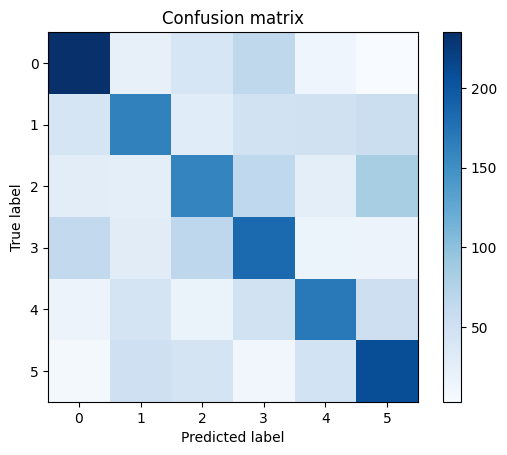

Most confusing classes: (2, 5)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(X_test_freq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

In [ ]:
def loadAudioFreqA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      mel_spec_aug = melSpectrogram(augmented_audio, sr)
      D.append(mel_spec_aug)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

## Time Domain Model With Augmentation

In [ ]:
def loadAudioTimeA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc, mel_spec], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      # extract zero crossing rate
      zcr = zeroCrossingRate(augmented_audio)
      # extract energy
      rms = energy(augmented_audio)
      # chroma stft
      cs = chromaStft(augmented_audio, sr)
      # mfcc
      mfc = mfcc(augmented_audio, sr)
      # extract mel spectrogram
      mel_spec = melSpectrogram(augmented_audio, sr).mean()
      combined_features = np.concatenate(([rms, cs, mfc, mel_spec], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
      D.append(combined_features)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [ ]:
D_time, Y_time = loadAudioTimeA(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [ ]:
D_time = np.array(D_time)
D_time.shape

(7877, 304)

In [ ]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_time = pd.DataFrame(Y_time)
df_time.head()

,0
0,FEA
1,FEA
2,FEA
3,HAP
4,HAP


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7877, 6)


In [ ]:
Y_time = one_hot_labels
Y_time.shape

(7877, 6)

In [ ]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [ ]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((7483, 200), (7483, 6), (394, 200), (394, 6))
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 198, 128)          512       
                                                                 
 batch_normalization_7 (Batc  (None, 198, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 198, 128)          0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 97, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
234/234 [==============================] - 9s 23ms/step - loss: 3.2763 - accuracy: 0.2983 - val_loss: 3.3933 - val_accuracy: 0.1433
Epoch 2/50
234/234 [==============================] - 5s 20ms/step - loss: 2.6442 - accuracy: 0.3350 - val_loss: 2.6381 - val_accuracy: 0.2527
Epoch 3/50
234/234 [==============================] - 5s 20ms/step - loss: 2.4370 - accuracy: 0.3523 - val_loss: 2.4055 - val_accuracy: 0.3249
Epoch 4/50
234/234 [==============================] - 5s 20ms/step - loss: 2.3020 - accuracy: 0.3671 - val_loss: 2.2626 - val_accuracy: 0.3635
Epoch 5/50
234/234 [==============================] - 4s 19ms/step - loss: 2.2028 - accuracy: 0.3751 - val_loss: 2.1980 - val_accuracy: 0.3676
Epoch 6/50
234/234 [==============================] - 5s 22ms/step - loss: 2.1218 - accuracy: 0.3830 - val_loss: 2.0443 - val_accuracy: 0.3917
Epoch 7/50
234/234 [==============================] - 4s 18ms/step - loss: 2.0317 - accuracy: 0.3826 - val_loss: 2.0686 - val_accuracy: 0.3388

In [ ]:
X_test_time,Y_test_time = loadAudioTimeA(D_test)
D_test_pca = pca.transform(X_test_time)

In [ ]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

,0
0,FEA
1,FEA
2,SAD
3,SAD
4,HAP


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(3333, 6)


In [ ]:
Y_time = one_hot_labels
Y_time.shape

(3333, 6)

105/105 [==============================] - 1s 5ms/step
Accuracy: 0.24332433243324333
F-score: 0.19634165130098163


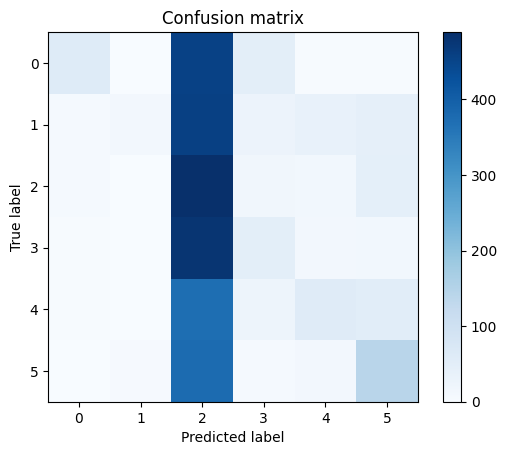

Most confusing classes: (3, 2)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

## Frequency Domain Model With Augmentation

In [ ]:
def loadAudioFreqA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      mel_spec_aug = melSpectrogram(augmented_audio, sr)
      D.append(mel_spec_aug)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [ ]:
D_freq, Y_freq = loadAudioFreqA(D_train)

In [ ]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

,0
0,FEA
1,FEA
2,HAP
3,HAP
4,HAP


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7865, 6)


In [ ]:
Y_freq = one_hot_labels
Y_freq.shape

(7865, 6)

In [ ]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [ ]:
D_freq.shape

(7865, 64, 256)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((7471, 64, 256), (7471, 6), (394, 64, 256), (394, 6))


In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(7471, 64, 256, 1) (394, 64, 256, 1)


In [ ]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 127, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
59/59 [==============================] - 5s 77ms/step - loss: 1.8375 - accuracy: 0.2198 - val_loss: 1.6859 - val_accuracy: 0.3173
Epoch 2/50
59/59 [==============================] - 3s 55ms/step - loss: 1.6414 - accuracy: 0.3077 - val_loss: 1.5879 - val_accuracy: 0.3426
Epoch 3/50
59/59 [==============================] - 3s 52ms/step - loss: 1.5776 - accuracy: 0.3436 - val_loss: 1.5598 - val_accuracy: 0.3426
Epoch 4/50
59/59 [==============================] - 3s 52ms/step - loss: 1.5448 - accuracy: 0.3578 - val_loss: 1.5260 - val_accuracy: 0.3477
Epoch 5/50
59/59 [==============================] - 3s 53ms/step - loss: 1.5123 - accuracy: 0.3744 - val_loss: 1.5302 - val_accuracy: 0.3706
Epoch 6/50
59/59 [==============================] - 3s 55ms/step - loss: 1.4854 - accuracy: 0.3950 - val_loss: 1.4899 - val_accuracy: 0.3807
Epoch 7/50
59/59 [==============================] - 3s 54ms/step - loss: 1.4730 - accuracy: 0.4009 - val_loss: 1.4944 - val_accuracy: 0.3883
Epoch 8/50
59

In [ ]:
X_test_freq,Y_test_freq = loadAudioFreqA(D_test)


In [ ]:
unicheck = np.unique(Y_test_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
df_freq = pd.DataFrame(Y_test_freq)
df_freq.head()

,0
0,FEA
1,FEA
2,SAD
3,SAD
4,HAP


In [ ]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(3351, 6)


In [ ]:
Y_freq = one_hot_labels
Y_freq.shape

(3351, 6)

In [ ]:
for i, array in enumerate(X_test_freq):
    X_test_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
X_test_freq = np.array(X_test_freq)
print( X_test_freq.shape)
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
#X_test_freq = x_test.reshape(( X_test_freq.shape[0],  X_test_freq.shape[1], X_test_freq.shape[2], 1))
print( X_test_freq.shape)

(3351, 64, 256)
(3351, 64, 256)


105/105 [==============================] - 1s 7ms/step
Accuracy: 0.4923903312444047
F-score: 0.4853821608203651


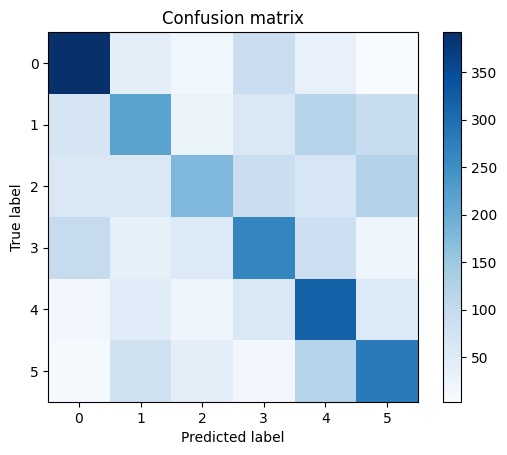

Most confusing classes: (2, 5)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(X_test_freq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, range(6))
plt.yticks(tick_marks, range(6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusinglabels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', most_confused_classes)

### VGG model implementation

In [71]:
D_freq, Y_freq = loadAudioFreq(D_train)

KeyboardInterrupt: ignored

In [46]:
D_freq[0].shape[1]

32

In [47]:
# perform padding to make input as same shape as that used in VGG
D_freq2 = []
for i, array in enumerate(D_freq):
  D_freq2.append(np.pad(array, ((0, 224 - array.shape[0]), (0, 224 - array.shape[1]))))
D_freq2 = np.array(D_freq2)

In [49]:
D_freq2[0].shape

(224, 224)

In [52]:
df_freq = pd.DataFrame(Y_freq)

# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)
Y_freq = one_hot_labels
Y_freq.shape

(2233, 6)


(2233, 6)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq2), np.array(Y_freq), test_size=0.05)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2121, 224, 224) (2121, 6) (112, 224, 224) (112, 6)


In [56]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(2121, 224, 224, 1) (112, 224, 224, 1)


In [68]:
weight_decay = 0.0005
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), 
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_regularizer=l2(weight_decay)))
# Dropout regularization with a dropout ratio of 0.5
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.SGD(lr=0.0005, momentum=0.9),
             metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_69 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_71 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [70]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=74,
                    # original model is 256, we use 64 to avoid memory error
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/74
 2/34 [>.............................] - ETA: 27s - loss: 9.2789 - accuracy: 0.2109

KeyboardInterrupt: ignored